# **Economic Car Accidents**

# **Reseach Question**

**(1) How significant of an impact do economic factors have on the frequency of car accidents that occur in the United States? In this project, the economic factors we chose to focus on are unemployment and inflation rates. There are other factors that impact the economy, but we found that US citizens are more directly impacted by these factors. In addition, although we would like to analyze more economic data, most of the data we came across on the web required us to pay for it, so we stuck to whatever data we could download or scrape for free.**




# **Background and Prior Research**


When you think of transportation in the United States, the first thing that comes to mind are cars. With over 250 million registered vehciles in the country, it remains the most common method of transportation to date. With this many vehiciles, we also face an ever increasing number of car accidents. With millions of accidents being reported, insruance companies have used this data to figure out in which situations accidents are more likely to occur. 

However, one factor that nobody ever really correlates with car accidents, is the economy. An article from *The Los Angeles Times* estimated that in 2014, car accidents tend to have an economoic toll of almost $1 trillion dollars (Fleming). These costs add up based off several factors, such as medical expenses, property damage, and air pollution just to name a few. While there are several indicators of how car accidents affect our economy, we wanted to see if the economy had an impact on the number of accidents that occur in a given year.


Sources: https://www.latimes.com/business/autos/la-fi-hy-economic-impact-of-traffic-accidents-20140529-story.html

**Notes:**

The only real trend that studies have shown between cars and the economy is that people are more likely to purchase a new car when the economy is doing well. 

**Potential Comparisons/Analysis Ideas:**
1. Unemployment rates vs. accidents per month/year
  a. we have both yearly avg and monthly rates so we can just filter all accidents in the given time frame and make month to month comparisons of the rate and the # of accidents
  b. 

2. Use multiple lienar regression and use economic factors and correlate with the number of accidents per year or month

3. Use some ML and try to predict what 2020 will be like 



# **Hypothesis**

1. We believe that there will be a positive linear correlation between inflation rates and the frequency of accidents that occur. 

2. In regards to unemployment, we believe that as the unemployment rate decreases, the number of accidents will increase.  

# Datasets

**Accidents:**  https://www.kaggle.com/sobhanmoosavi/us-accidents

**Unemployment Rates Yearly:** https://data.bls.gov/timeseries/LNU04023554&series_id=LNU04000000&series_id=LNU03023554&series_id=LNU03000000&years_option=all_years&periods_option=specific_periods&periods=Annual+Data

**GDP Data:** https://www.thebalance.com/us-gdp-by-year-3305543

**Inflation Rates:** https://www.usinflationcalculator.com/inflation/current-inflation-rates/


# **Setup & Packages**

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup

In [41]:
#Import Downloaded Datasets
df_Accidents = pd.read_csv('US_Accidents_June20.csv')
df_Unemployment = pd.read_excel('UnemploymentRates.xlsx')
df_Unemployment_Rate = pd.read_excel('UnemployedYearlyRates.xlsx')
df_Inflation_Rates = pd.read_excel('InflationRates.xlsx')


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (32,33,34,35,36,37,38,39,40,41,42,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# **Data Cleaning**

In [42]:
#WebScrape for GDP data
GDP_URL = 'https://www.thebalance.com/us-gdp-by-year-3305543'
page = requests.get(GDP_URL)
soup = BeautifulSoup(page.text, 'html.parser')


gdp_Table = soup.find('table', attrs={'class':"mntl-sc-block-table__table"})
list_a, list_b, list_c, list_d = [], [], [], []

for row in gdp_Table.findAll('tr'):

  cells=row.findAll('td')

  try:
    list_a.append(cells[0].find(text=True))
    list_b.append(cells[1].find(text=True))
    list_c.append(cells[2].find(text=True))
    list_d.append(cells[3].find(text=True))
  except:
    break

df_GDP = pd.DataFrame({
    'Year' : list_a,
    'Nominal_GDP' : list_b,
    'Real_GDP' : list_c,
    'GDP Growth Rate' : list_d
})

df_GDP = df_GDP.iloc[1:]

#Convert to int values
df_GDP['Year'] = pd.to_numeric(df_GDP['Year'])


#Might have to convert to string and then integer to remove '$' and store as integer
#df_GDP.Nominal_GDP.str.replace('$','')
#df_GDP.Real_GDP.str.replace('$','')

#df_GDP['Nominal_GDP'] = pd.to_numeric(df_GDP['Nominal_GDP'])
#df_GDP['Real_GDP'] = pd.to_numeric(df_GDP['Real_GDP'])

df_GDP = df_GDP[df_GDP['Year'] > 1999]

df_GDP.dtypes
df_GDP.head()


,Year,Nominal_GDP,Real_GDP,GDP Growth Rate
72,2000,$10.252,$13.131,4.1%
73,2001,$10.582,$13.262,1.0%
74,2002,$10.936,$13.493,1.7%
75,2003,$11.458,$13.879,2.9%
76,2004,$12.214,$14.406,3.8%


In [43]:
def year_split(start):
    date = str(start)
    split = date.split(' ')
    year = split[0].split('-')
    month = year[1]
    return int(year[0])

def month_split(start):
    date = str(start)
    split = date.split(' ')
    year = split[0].split('-')
    month = year[1]
    return int(month)


In [44]:
df_Accidents = df_Accidents.assign(Year = df_Accidents.get('Start_Time').apply(year_split), Month = df_Accidents.get('Start_Time').apply(month_split))
df_Accidents_Yearly = df_Accidents.groupby('Year').count().reset_index()
df_accidents = df_Accidents[['Year','Month','Start_Time', 'Severity','Start_Lat', 'Start_Lng','State','Zipcode', 'Timezone']]
df_accidents

,Year,Month,Start_Time,Severity,Start_Lat,Start_Lng,State,Zipcode,Timezone
0,2016,2,2016-02-08 05:46:00,3,39.865147,-84.058723,OH,45424,US/Eastern
1,2016,2,2016-02-08 06:07:59,2,39.928059,-82.831184,OH,43068-3402,US/Eastern
2,2016,2,2016-02-08 06:49:27,2,39.063148,-84.032608,OH,45176,US/Eastern
3,2016,2,2016-02-08 07:23:34,3,39.747753,-84.205582,OH,45417,US/Eastern
4,2016,2,2016-02-08 07:39:07,2,39.627781,-84.188354,OH,45459,US/Eastern
...,...,...,...,...,...,...,...,...,...
497789,2017,7,2017-07-30 01:26:14,3,33.975681,-117.335442,CA,92507,US/Pacific
497790,2017,7,2017-07-30 00:59:41,2,34.047970,-118.266563,CA,90017,US/Pacific
497791,2017,7,2017-07-30 02:10:23,3,34.029751,-118.405449,CA,90034,US/Pacific
497792,2017,7,2017-07-30 02:22:20,3,34.061096,-118.165329,CA,91754,US/Pacific


In [45]:
#Convert start/end_time from object to datetime object so we can run time queries easier
#df_Accidents['Start_Time'] = pd.to_datetime(df_Accidents['Start_Time'])
#print(df_Accidents[df_Accidents['Start_Time'].str.len() > 19].count())
#df_Accidents_Yearly = df_Accidents.groupby(df_Accidents.Start_Time.dt.year)
#df_Accidents_Yearly.head()
#df_Accidents.dtypes

In [46]:
#We can consolidate this into one graph if we fix datetime error above

#2016
df_2016 = df_accidents[df_accidents.get('Year') == 2016]
df_2016 = df_2016.groupby('Month').count().reset_index()
#df_2016 = df_2016[['Month']]
#df_2016 = df_2016.assign(Count = df_2016.get('Year'))
#2017
df_2017 = df_accidents[df_accidents.get('Year') == 2017]
df_2017 = df_2017.groupby('Month').count().reset_index()
#2018
df_2018 = df_accidents[df_accidents.get('Year') == 2018]
df_2018 = df_2018.groupby('Month').count().reset_index()
#2019
df_2019 = df_accidents[df_accidents.get('Year') == 2019]
df_2019 = df_2019.groupby('Month').count().reset_index()


In [47]:
df_Inflation_Rates = df_Inflation_Rates[df_Inflation_Rates['Year'] > 2015]

In [48]:
#Remove this cell later
df_temp = df_Inflation_Rates.iloc[3, :]
df_temp

Year    2017.0
Jan        2.5
Feb        2.7
Mar        2.4
Apr        2.2
May        1.9
Jun        1.6
Jul        1.7
Aug        1.9
Sep        2.2
Oct        2.0
Nov        2.2
Dec        2.1
Ave        2.1
Name: 3, dtype: float64

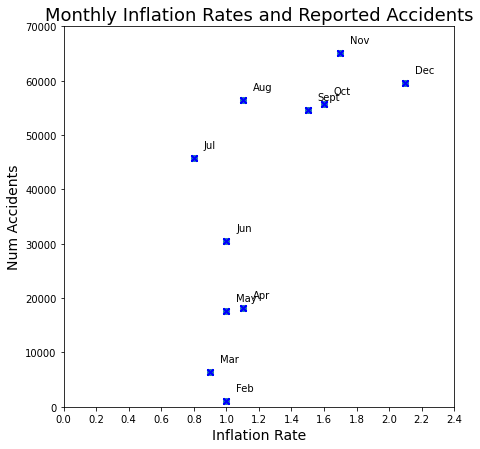

In [49]:
#Stuck trying to find a way to merge a row with a column, transpose doesnt work
#Since we dont have too many data points for now it was just quicker to hard code the values
#NOTE: 2016 didnt have a number of accidents reported for January
data_Inflation_Accidents_2016 = [['Feb', 985, 1.0], ['Mar', 6329, 0.9],
                                ['Apr', 18088, 1.1], ['May',17610, 1.0],
                               ['Jun', 30527, 1.0], ['Jul', 45759, 0.8],
                               ['Aug', 56425, 1.1], ['Sept', 54664, 1.5],
                               ['Oct', 55628, 1.6],['Nov', 65010, 1.7],
                               ['Dec', 59568, 2.1]]
df_Inflation_Accidents_2016 = pd.DataFrame(data_Inflation_Accidents_2016, columns = ['Month', 'Accidents', 'InflationRate'])

x = df_Inflation_Accidents_2016['InflationRate'].values
y = df_Inflation_Accidents_2016['Accidents'].values
types = df_Inflation_Accidents_2016.reset_index()['Month'].values

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(x, y)

ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4 ])
ax.set_xlim((0,2.4))
ax.set_ylim((0, 70000))

ax.set_xlabel('Inflation Rate', fontsize=14)
ax.set_ylabel('Num Accidents', fontsize=14)
ax.set_title('Monthly Inflation Rates and Reported Accidents', fontsize=18)

for i, txt in enumerate(types):
    ax.annotate(txt, (x[i], y[i]), xytext=(10,10), textcoords='offset points')
    plt.scatter(x, y, marker='x', color='blue')


In the next  plot, we compare the monthly inflation rates in the United States with the number of accidents occuring each month. For 2016, we see that for the first half the year the interst rates tend to stay between roughly 0.8 and 1.4%, and then steadily increasing from August onward. From a simple glance, it seems that as the inflation rate increases, the number of accidents that occur also icnreases. 

Before we can make any assumptions, we must note that the dataset from which we collected the accident data only contains accident reports from February of 2016 to June of 2020. However, it seems that the dataset doesn't have too many accidents reported in the early months of 2016, making these outliers in this plot. 

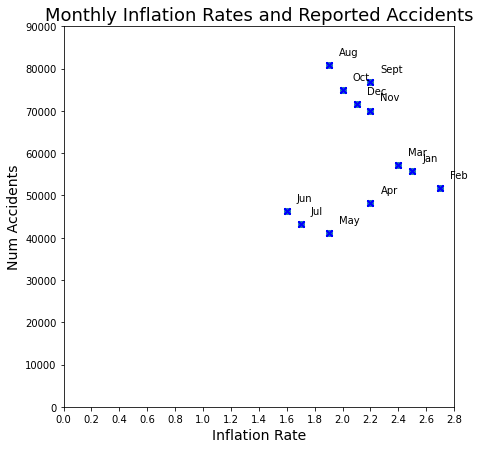

In [50]:
data_Inflation_Accidents_2017 = [['Jan', 55680, 2.5], ['Feb', 51640, 2.7], 
                                 ['Mar', 57283, 2.4],['Apr', 48087, 2.2], 
                                 ['May',41106, 1.9], ['Jun', 46221, 1.6], 
                                 ['Jul', 43226, 1.7],['Aug', 80878, 1.9], 
                                 ['Sept', 76820, 2.2], ['Oct', 74905, 2.0],
                                 ['Nov', 70074, 2.2],['Dec', 71569, 2.1]]
df_Inflation_Accidents_2017 = pd.DataFrame(data_Inflation_Accidents_2017, columns = ['Month', 'Accidents', 'InflationRate'])

x = df_Inflation_Accidents_2017['InflationRate'].values
y = df_Inflation_Accidents_2017['Accidents'].values
types = df_Inflation_Accidents_2017.reset_index()['Month'].values

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(x, y)

ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8 ])
ax.set_xlim((0,2.8))
ax.set_ylim((0, 90000))

ax.set_xlabel('Inflation Rate', fontsize=14)
ax.set_ylabel('Num Accidents', fontsize=14)
ax.set_title('Monthly Inflation Rates and Reported Accidents', fontsize=18)

for i, txt in enumerate(types):
    ax.annotate(txt, (x[i], y[i]), xytext=(10,10), textcoords='offset points')
    plt.scatter(x, y, marker='x', color='blue')

In 2017, it is clear that the inflation rates were consistently higher than they were the previous year. In 2016, the average inflation rate was 1.3% and by the end of 2017 the average rate had increased to 2.1%. This time around, the first half of the year appears to have higher inflation rates than the second half. In 2017, sources indicate that final-demand prices for goods, services, and construction had increased significaltly since 2016. One impact of increased inflation rates is that it lowers the cost to borrow money. This can lead to more people purchasing new vehicles, thus resulting in more cars on the road. 

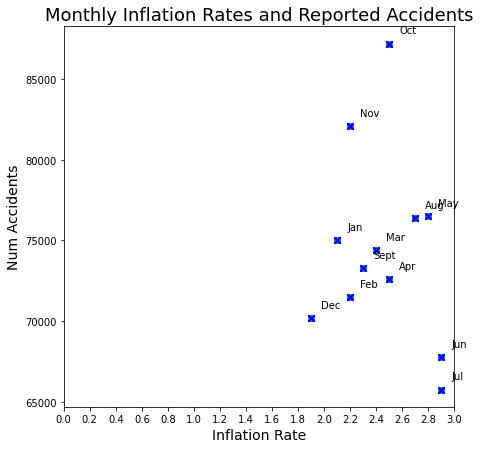

In [51]:
data_Inflation_Accidents_2018 = [['Jan', 74999, 2.1], ['Feb', 71464, 2.2], 
                                 ['Mar', 74423, 2.4],['Apr', 72592, 2.5], 
                                 ['May',76475, 2.8], ['Jun', 67777, 2.9], 
                                 ['Jul', 65749, 2.9],['Aug', 76381, 2.7], 
                                 ['Sept', 73277, 2.3], ['Oct', 87195, 2.5],
                                 ['Nov', 82078, 2.2],['Dec', 70205, 1.9]]
df_Inflation_Accidents_2018 = pd.DataFrame(data_Inflation_Accidents_2018, columns = ['Month', 'Accidents', 'InflationRate'])

x = df_Inflation_Accidents_2018['InflationRate'].values
y = df_Inflation_Accidents_2018['Accidents'].values
types = df_Inflation_Accidents_2018.reset_index()['Month'].values

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(x, y)

ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0 ])
ax.set_xlim((0,3.0))
#ax.set_ylim((0, 85000))

ax.set_xlabel('Inflation Rate', fontsize=14)
ax.set_ylabel('Num Accidents', fontsize=14)
ax.set_title('Monthly Inflation Rates and Reported Accidents', fontsize=18)

for i, txt in enumerate(types):
    ax.annotate(txt, (x[i], y[i]), xytext=(10,10), textcoords='offset points')
    plt.scatter(x, y, marker='x', color='blue')

The inflation rates continued to increase into 2018 and the most surprising thing is that the rates never went below 2% except in December which had a rate of 1.9%. Historically, data shows that high inflation rates have lead to reduced unemployment. With more people employed, this leads to more people commutting to their jobs, increasing traffic and the likelihood for accidents to occur. In addition, the number of accidents occuring each month in 2018 was over 65000 each month, resulting in nearly twice as many accidents as 2017. The data from this year supports our hypothesis that there is a positive correlation between inflation rate and accident frequency.

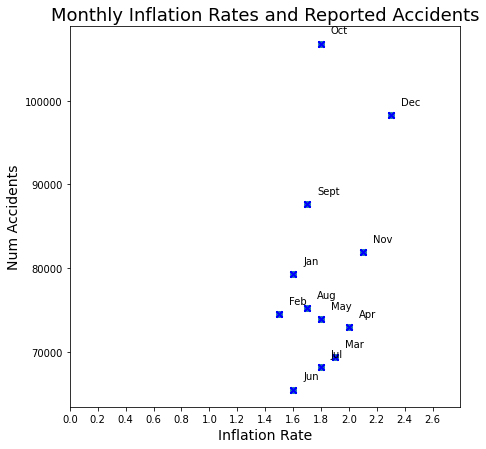

In [52]:
data_Inflation_Accidents_2019 = [['Jan', 79276, 1.6], ['Feb', 74559, 1.5], 
                                 ['Mar', 69401, 1.9],['Apr', 73001, 2.0], 
                                 ['May',73864, 1.8], ['Jun', 65501, 1.6], 
                                 ['Jul', 68234, 1.8],['Aug', 75246, 1.7], 
                                 ['Sept', 87659, 1.7], ['Oct', 106817, 1.8],
                                 ['Nov', 81894, 2.1],['Dec', 98281, 2.3]]
df_Inflation_Accidents_2019 = pd.DataFrame(data_Inflation_Accidents_2019, columns = ['Month', 'Accidents', 'InflationRate'])

x = df_Inflation_Accidents_2019['InflationRate'].values
y = df_Inflation_Accidents_2019['Accidents'].values
types = df_Inflation_Accidents_2019.reset_index()['Month'].values

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(x, y)

ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6])
ax.set_xlim((0,2.8))


ax.set_xlabel('Inflation Rate', fontsize=14)
ax.set_ylabel('Num Accidents', fontsize=14)
ax.set_title('Monthly Inflation Rates and Reported Accidents', fontsize=18)

for i, txt in enumerate(types):
    ax.annotate(txt, (x[i], y[i]), xytext=(10,10), textcoords='offset points')
    plt.scatter(x, y, marker='x', color='blue')

In 2019, there starts to be a significant decrease in interest rates, yet the number of accidents is just as high as 2018. October of 2019 reported about 106,000 accidents, making it the highest number of recorded accidents amongst all four years. However, in the inflation rates for this year mostly ranged from 1.6-1.8%, but the accidents counts were between 70-80,000 reports. 

<Figure size 1080x1080 with 0 Axes>

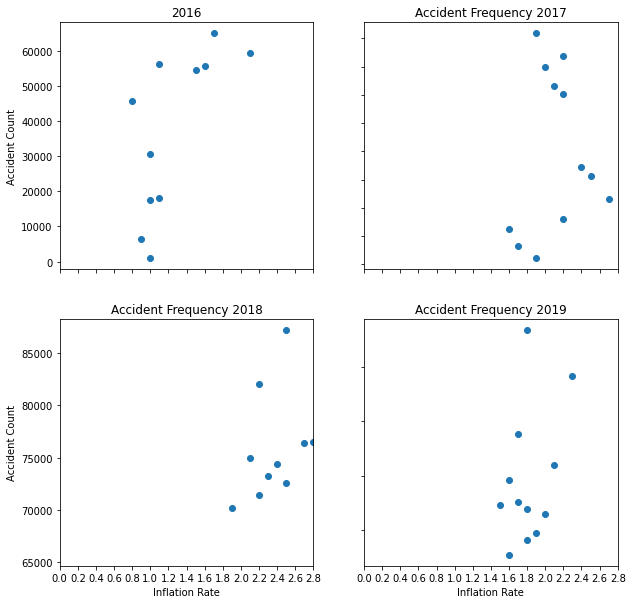

In [53]:
plt.figure(figsize=(15,15))
fig, axs = plt.subplots(2, 2, figsize=(10,10))

axs[0,0].scatter(df_Inflation_Accidents_2016['InflationRate'].values, df_Inflation_Accidents_2016['Accidents'].values)
axs[0, 0].set_title('2016')
types_2016 = df_Inflation_Accidents_2016.reset_index()['Month'].values

axs[0,1].scatter(df_Inflation_Accidents_2017['InflationRate'].values, df_Inflation_Accidents_2017['Accidents'].values)
axs[0, 1].set_title('Accident Frequency 2017')
types_2017 = df_Inflation_Accidents_2017.reset_index()['Month'].values

axs[1,0].scatter(df_Inflation_Accidents_2018['InflationRate'].values, df_Inflation_Accidents_2018['Accidents'].values)
axs[1, 0].set_title('Accident Frequency 2018')
types_2018 = df_Inflation_Accidents_2018.reset_index()['Month'].values

axs[1,1].scatter(df_Inflation_Accidents_2019['InflationRate'].values, df_Inflation_Accidents_2019['Accidents'].values)
axs[1, 1].set_title('Accident Frequency 2019')
types_2019 = df_Inflation_Accidents_2019.reset_index()['Month'].values

for ax in axs.flat:
    ax.set(xlabel='Inflation Rate', ylabel='Accident Count')

for ax in axs.flat:
    ax.label_outer()

for ax in axs.flat:
  ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8])
  ax.set_xlim((0,2.8))

# for i, txt in enumerate(types_2016):
#     ax.annotate(txt, (x[i], y[i]), xytext=(10,10), textcoords='offset points')
#     plt.scatter(x, y, color='blue')


# for i, txt in enumerate(types_2017):
#     ax.annotate(txt, (x[i], y[i]), xytext=(10,10), textcoords='offset points')
#     plt.scatter(x, y, color='blue')


# for i, txt in enumerate(types_2018):
#     ax.annotate(txt, (x[i], y[i]), xytext=(10,10), textcoords='offset points')
#     plt.scatter(x, y, color='blue')


# for i, txt in enumerate(types_2019):
#     ax.annotate(txt, (x[i], y[i]), xytext=(10,10), textcoords='offset points')
#     plt.scatter(x, y, color='blue')





**General Observations**

An interesting observation to note is that the Spring and Summer months appear to have fewer accidents than Fall and Winter months. As expected, during the Fall and Winter seasons road conditions tend to become more dangerous due to rain and snow on the roads. 

<Figure size 720x720 with 0 Axes>

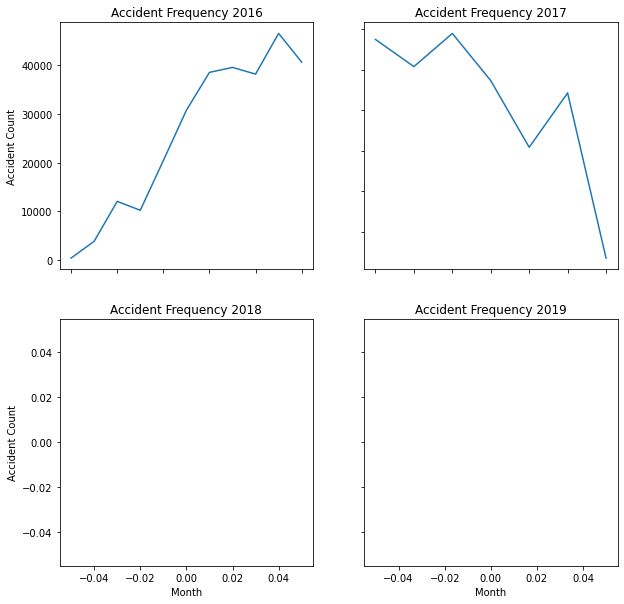

In [54]:
plt.figure(figsize=(10,10))
fig, axs = plt.subplots(2, 2, figsize=(10,10))

axs[0,0].plot(df_2016['Month'], df_2016['State'])
axs[0, 0].set_title('Accident Frequency 2016')

axs[0,1].plot(df_2017['Month'], df_2017['State'])
axs[0, 1].set_title('Accident Frequency 2017')

axs[1,0].plot(df_2018['Month'], df_2018['State'])
axs[1, 0].set_title('Accident Frequency 2018')

axs[1,1].plot(df_2019['Month'], df_2019['State'])
axs[1, 1].set_title('Accident Frequency 2019')

for ax in axs.flat:
    ax.set(xlabel='Month', ylabel='Accident Count')

for ax in axs.flat:
    ax.label_outer()

[Text(0, 0, '2000'),
 Text(0, 0, '2001'),
 Text(0, 0, '2002'),
 Text(0, 0, '2003'),
 Text(0, 0, '2004'),
 Text(0, 0, '2005'),
 Text(0, 0, '2006'),
 Text(0, 0, '2007'),
 Text(0, 0, '2008'),
 Text(0, 0, '2009'),
 Text(0, 0, '2010'),
 Text(0, 0, '2011'),
 Text(0, 0, '2012'),
 Text(0, 0, '2013'),
 Text(0, 0, '2014'),
 Text(0, 0, '2015'),
 Text(0, 0, '2016'),
 Text(0, 0, '2017'),
 Text(0, 0, '2018'),
 Text(0, 0, '2019')]

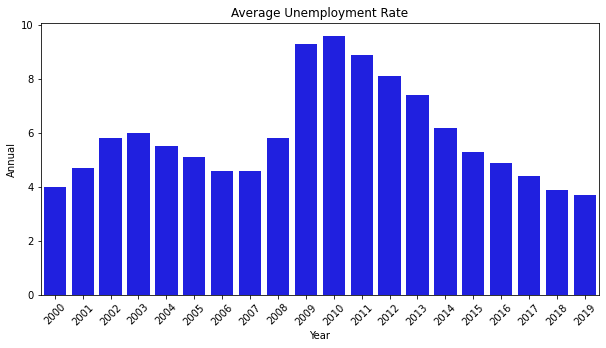

In [38]:
plt.figure(figsize=(10,5))
df_Unemployment_Rate = df_Unemployment_Rate[df_Unemployment_Rate['Year'] > 1999]
ax = sns.barplot(x=df_Unemployment_Rate['Year'], y=df_Unemployment_Rate['Annual'],
            data=df_Unemployment_Rate, ci=None, color='blue')

ax.set_title('Average Unemployment Rate')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


